In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import optuna
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Kathmandu-Precipitation/data/Outlier-removed-dataset.csv")
features = [ i for i in df.columns if i not in ["precipitation","datetime"]]
target = ["precipitation"]
X = df[features]
y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)


In [ ]:
# time series validation

In [ ]:
from lightgbm import LGBMRegressor, early_stopping
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    mean_squared_log_error,
    mean_absolute_percentage_error,
)
from sklearn.model_selection import TimeSeriesSplit
import optuna
import pandas as pd

# Objective Function for Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-9, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-9, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'n_estimators': 1000,
        'random_state': 42,
        'objective': 'regression',
        'metric': 'rmse',
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=8)  # Use 5 splits for cross-validation

    # Placeholder for metrics across folds
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    medae_scores = []
    smape_scores = []

    # Perform time series cross-validation
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[early_stopping(stopping_rounds=50)],
        )

        # Make predictions
        preds = model.predict(X_val)

        # Calculate metrics for this fold
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        mae = mean_absolute_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        medae = median_absolute_error(y_val, preds)
        smape = np.mean(2 * np.abs(preds - y_val) / (np.abs(y_val) + np.abs(preds) + 1e-8)) * 100

        # Store metrics
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        medae_scores.append(medae)
        smape_scores.append(smape)

    # Log metrics to Optuna
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    avg_medae = np.mean(medae_scores)
    avg_smape = np.mean(smape_scores)

    trial.set_user_attr("avg_rmse", avg_rmse)
    trial.set_user_attr("avg_mae", avg_mae)
    trial.set_user_attr("avg_r2", avg_r2)
    trial.set_user_attr("avg_medae", avg_medae)
    trial.set_user_attr("avg_smape", avg_smape)

    # Return average RMSE as the optimization objective
    return avg_rmse


# Load and prepare data
features = [col for col in df.columns if col not in ["datetime", "precipitation",
                                                     "solarenergy", "orographic_precipitation_potential",
                                                     "urban_heat_island_effect_refined", "valley_temperature_inversion_index", "windspeed", "winddir"]]
X = df[features]  # Features
y = df['precipitation']  # Target

# Optuna hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Extract best parameters
best_params = study.best_params
best_params.update({'objective': 'regression', 'random_state': 42, 'n_jobs': -1})

# Train final model with best parameters
final_model = LGBMRegressor(**best_params)
final_model.fit(X, y)  # Train on the entire dataset

# Evaluate the final model (optional: use a holdout test set if available)
test_preds = final_model.predict(X)  # Predict on the same dataset for now
test_rmse = np.sqrt(mean_squared_error(y, test_preds))
test_mae = mean_absolute_error(y, test_preds)
test_r2 = r2_score(y, test_preds)
test_medae = median_absolute_error(y, test_preds)
test_smape = np.mean(2 * np.abs(test_preds - y) / (np.abs(y) + np.abs(test_preds) + 1e-8)) * 100

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Median Absolute Error: {test_medae:.4f}")
print(f"Test SMAPE: {test_smape:.4f}%")
print(f"Best Params: {best_params}")

# Print results of all trials
for trial in study.trials:
    trial_number = trial.number
    trial_value = trial.value  # The objective value (average RMSE in this case)
    trial_user_attrs = trial.user_attrs  # User-defined attributes

    print(f"Trial {trial_number}:")
    print(f"  Objective Value (Average RMSE): {trial_value:.4f}")
    for metric_name, metric_value in trial_user_attrs.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print("-" * 50)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
(X.columns)

Index(['tempmax', 'tempmin', 'humidity', 'sealevelpressure', 'cloudcover',
       'season_sin', 'season_cos'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
seasons_dict = {'Spring': 1,
                'Summer': 2,
                'Monsoon': 3,
                'Autumn': 4,
                'Winter': 5
                }

def get_season(date):
    """
    Function to determine the season in Nepal based on the given date.
    Args:
        date (pd.Timestamp): A datetime object.
    Returns:
        str: The season corresponding to the date.
    """
    month = date.month
    day = date.day

    # Spring: Mid-March to Mid-May (blooming season, pre-monsoon)
    if (month == 3 and day >= 15) or (month == 4) or (month == 5 and day <= 15):
        return "Spring"  # 2 months

    # Summer/Monsoon:
    # - Early Summer (pre-monsoon heat): Mid-May to Mid-June
    # - Peak Monsoon: Mid-June to Mid-September
    elif (month == 5 and day > 15) or (month == 6 and day <= 15):
        return "Summer" # 1 month
    elif (month == 6 and day > 15) or (month == 7) or (month == 8) or (month == 9 and day <= 15):
        return "Monsoon" # 3 months

    # Autumn: Mid-September to Mid-November (post-monsoon, harvest season)
    elif (month == 9 and day > 15) or (month == 10) or (month == 11 and day <= 15):
        return "Autumn" # 2 months

    # Winter: Mid-November to Mid-March (cold, dry season)
    else: # ( month == 11 and day > 15 ) or ( month == 12 ) or ( month == 1 ) or ( month == 2 )or ( month == 3 and day <15 )
        return "Winter" # 4 months

def input_testing_for_pred():
    print(f"To know the data, visit : https://www.visualcrossing.com/weather-query-builder/")
    # temp = []
    # for i in range(4):
    #     if i == 3:
    #         temp.append((float(input(f"Enter the temperature today's temp (in Fahrenheit) : "))))
    #     else:
    #         temp.append((float(input(f"Enter the temperature of {3-i} day earlier (in Fahrenheit) : "))))
    # temp=  float(input("Enter the temperature: "))

    date_input = input("Enter the date: (YYYY-MM-DD) between YYYY-04-DD,YYYY-10-DD ")
    date = pd.to_datetime(date_input) # date is a Timestamp object here
    # wind_dir = float(input("Enter the wind direction (in degrees) : "))
    # wind_speed = float(input("Enter the wind speed : "))
    # precipitation_lag_1_days = float(input("Enter the precipitation value of one day earlier (im mm): "))
    # valley_temperature_inversion_index = (temp -dew) / 500
    # new###
    humidity = float(input(f"Enter humidity for {date}: "))
    # humidity_lag_2_days = float(input(f"Enter the humidity of 2 days earlier (in Fahrenheit) : "))
    while True:
        try:
            dew = float(input(f"Enter the dew value (in Fahrenheit) for {date} : "))
            break  # Exit the loop if conversion is successful
        except ValueError:
            print("Invalid input. Please enter a numerical value for dew point.")
    sealevelpressure = float(input(f"Enter the sealeavelpressure for {date}: "))
    tempmax =  float(input(f"Enter the maximum temp for {date}: "))
    tempmin =  float(input(f"Enter the minimum temp for {date}: "))
    cloudcover = float(input(f"Enter the cloud coverage for {date}: "))
    # solarenergy= float(input("Enter the solar energy for today: "))
    # precipitation_lag_1_days = float(input("Enter the precipitation value one day earlier: ")) * 25.4
    # Convert Timestamp to Series to use .dt accessor
    date_series = pd.Series([date])
    month = date_series.dt.month.iloc[0]

    # season = get_season(date) ( commented because it's used below)
    # month_sin = np.sin(2 * np.pi * month / 12)
    # month_cos = np.cos(2 * np.pi * month / 12)
    # heat_index = temp -((100 - humidity)/5)
    # dew_point_depression = temp- dew
    # orographic_precipitation_potential = wind_speed * np.sin(np.radians(wind_dir)) * humidity
    # urban_heat_island_effect_refined = temp - dew + sealevelpressure/ 1000 - cloudcover / 100
    # cloud_cover_temp_interaction = cloudcover * temp
    # cloud_cover_humidity_interaction = cloudcover * humidity
    # wind_dir_sin = np.sin(np.radians(wind_dir))
    # wind_dir_cos = np.cos(np.radians(wind_dir))
    # moisture_flux = wind_speed * np.sin(np.radians(wind_dir * humidity))
    # temperature_inversion_index = (temp[-1] * dew) / 500 # 500 meters is the elevation difference

    season = get_season(date)
    season_number = seasons_dict[season]

    season_sin = np.sin(2 * np.pi * season_number / 5)
    season_cos = np.cos(2 * np.pi * season_number / 5)

    # Calculate EMA for the last 4 temperature values
    # temp_series = pd.Series(temp)
    # temp_EMA_3_days = temp_series.ewm(span=3, adjust=False).mean().iloc[-1]

    data = {
        "tempmax":[tempmax],
        "tempmin":[tempmin],
            # "temp": [temp[-1]],
            # 'dew':[dew],
        'humidity':[humidity],
            # 'winddir':[wind_dir],
        'sealevelpressure':[sealevelpressure],
        'cloudcover':[cloudcover], # Added cloudcover here
            # 'month':[month], # Added month here

            # 'temp_EMA_3_days':[temp_EMA_3_days],
            # 'humidity_lag_2_days':[humidity_lag_2_days],
            # 'month_sin':[month_sin],
            # 'month_cos':[month_cos],
            # 'season_number':[season_number], # Added season_number here
        'season_sin':[season_sin],
        'season_cos':[season_cos],
            # 'heat index':[heat_index],
            # 'dew_point_depression':[dew_point_depression],

            # 'winddir_sin':[wind_dir_sin],
            # 'winddir_cos':[wind_dir_cos],
            # 'moisture_flux':[moisture_flux],
            # 'orographic_precipitation_potential':[orographic_precipitation_potential],
            # 'cloud_cover_temp_interaction':[cloud_cover_temp_interaction],
            # 'cloud_cover_humidity_interaction':[cloud_cover_humidity_interaction],
            # 'urban_heat_island_effect_refined':[urban_heat_island_effect_refined],
            # 'valley_temperature_inversion_index':[valley_temperature_inversion_index],
            # 'precipitation_lag_1_days':[precipitation_lag_1_days]
            }
    df = pd.DataFrame(data)

    return df

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test_final - test_preds

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

NameError: name 'y_test_final' is not defined

In [ ]:
# # september 28,2024 (the day which rained as hell)
# X_future_dry = input_testing_for_pred()
X_future_dry_copy = X_future_dry.copy(deep=True)
# print(f"Features: {X_future_dry_copy.iloc[:,:]}")
# if model.predict(X_future_dry_copy.iloc[:,:]) <=0:
#   print("0mm")
# else:
#   print(f"{X_future_dry_copy.iloc[:,:]}mm")
print(f"{ final_model.predict(X_future_dry_copy.iloc[:,:])} mm")

NameError: name 'X_future_dry' is not defined

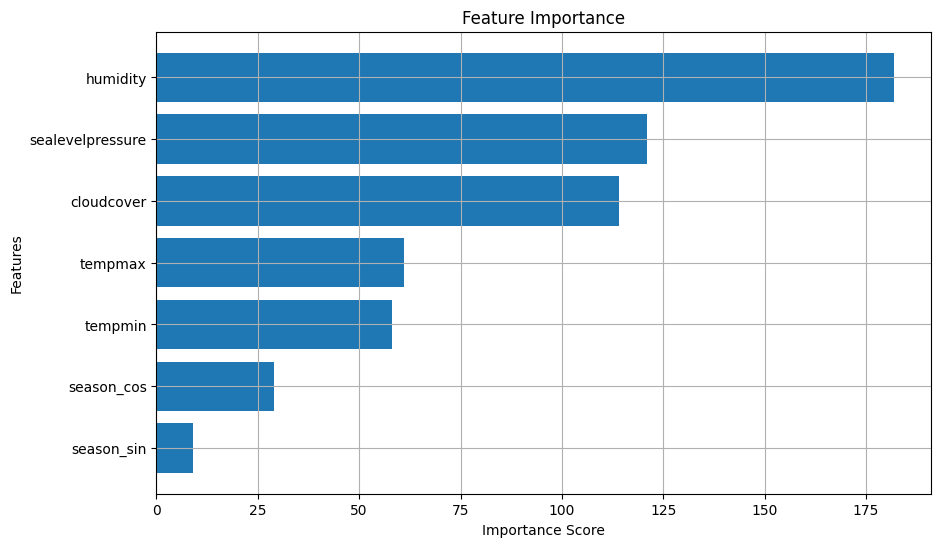

In [ ]:
# Extract feature importance
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.show()

In [ ]:
# end of spring
X_future_dry = input_testing_for_pred()
X_future_dry_copy = X_future_dry.copy(deep=True)
# print(f"Features: {X_future_dry_copy.iloc[:,:]}")
# if model.predict(X_future_dry_copy.iloc[:,:]) <=0:
#   print("0mm")
# else:
#   print(f"{X_future_dry_copy.iloc[:,:]}mm")
print(f"{ final_model.predict(X_future_dry_copy.iloc[:,:])} mm")